In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**<h2> MADS: Milestone II (Team 10) - Preprocessing, Features Engineering, and Supervised Learning</h2>**
<h3> Topic: Machine learning on duty: solving consumer complaints and improving satisfaction!</h3>
<h4> Authors: Chih-Han Yeh (yehch), Yi-Hsin Chien (yihsinc), Weiming Chen ( weimingc) </h4>
<h4> Mentor: Alexis Castellanos</h4>

**<h3>Project Overview</h3></br>**
In response to the escalating volume of consumer complaints and the complexities involved in addressing them promptly, our dedicated team is committed to leveraging data-driven strategies to enhance our comprehension of these complaints. Our overarching objective is to develop efficient techniques for managing and resolving complaints by predicting which ones are likely to be disputed by consumers and unveiling concealed patterns or clusters within the narrative of these complaints.

**<h3>Environment Setting</h3></br>**
Importing libraries we need for our project.

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.8 MB/s eta 0:00:00


In [ ]:
!pip install keras

In [ ]:
# Built-in libraries
import re
import string
import warnings

# Third-party libraries for data handling and processing
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm import tqdm

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import KeyedVectors

# Pre-processing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler
from imblearn.over_sampling import SMOTE

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


# Miscellaneous
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tqdm.pandas()
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# files
file_path_01 = '/content/drive/MyDrive/Colab Notebooks/complaints.csv'

file_path_03 = '/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin'

# import DATA
DATA = pd.read_csv(file_path_01)

print(DATA.shape)

(4028530, 18)


# **CFBP Dataset**

**•	Where the datasets or API resource is located </br>**
Our dataset is drawn from the CFPB Consumer Complaint Database, encompassing complaint receipt dates, product types, issues, consumer narratives, and various other attributes. We downloaded the dataset from the link: https://files.consumerfinance.gov/ccdb/complaints.csv.zip.

**•	What formats they returned/used</br>**
The format of our dataset is a CSV file.

**•	What were the important variables contained in them</br>**
The important variables are Product, Sub-product, Issue, Sub-issue, Consumer complaint narrative, Company public response, Company, State, Zip code, Company response to Consumer, and Consumer disputed.

**•	How many records you used or retrieved (if using an API)</br>**
Our dataset contains 4,101,381 entries and is around 2.61 GB.

**•	What time periods they covered (if there is a time element)</br>**
The period of our dataset is from 2011-12-01 to 2023-09-22.

**•	What initial preprocessing was required to handle noisy or missing data</br>**
A strategic methodology is essential to address the intricacies of consumer complaints effectively. Firstly, a focused analysis of the "Credit reporting, credit repair services, or other personal consumer reports" category is imperative due to the high frequency of complaints within this segment. Specialized models and analysis pipelines for this category will enable us to extract detailed and specific insights. Before delving into Word Embedding and Feature Vectorization, it's paramount to maintain the integrity of our dataset. We must address columns with persistent missing data, such as "Tags," by removing or blaming them. Essential columns with incomplete data should be rectified using central tendency measures or interpolation. Following this, optimizing our feature set by eliminating redundant or irrelevant attributes, enhancing the model's precision, and reducing overfitting risks is vital. Word Embedding and Feature Vectorization, mainly deriving attributes from the "Consumer complaint narrative," is our subsequent focus. By extracting key insights such as sentiment scores, narrative lengths, and keyword frequencies, we add depth to our dataset. Translating categorical variables, like product types, into numerical formats will further streamline our data structure.

# **Feature Engineering**

**Step 1: Deep Dive into Credit Reporting Complaints and few Companies**



*   **Credit Reporting**

> From our exploratory data analysis (EDA), we discerned that the "Credit reporting, credit repair services, or other personal consumer reports" category constitutes the largest segment of our dataset. Delving further into the Sub-Product columns revealed a pronounced data imbalance. Specifically, credit reporting dominates the data, comprising approximately 54%. As a result, our team has decided to concentrate on credit reporting, ensuring that our insights are precise and pertinent rather than attempting to generalize our analysis across all sub-products. Please see the chart below for a detailed visualization.

Credit Reporting accounts for 53.6% of the dataset


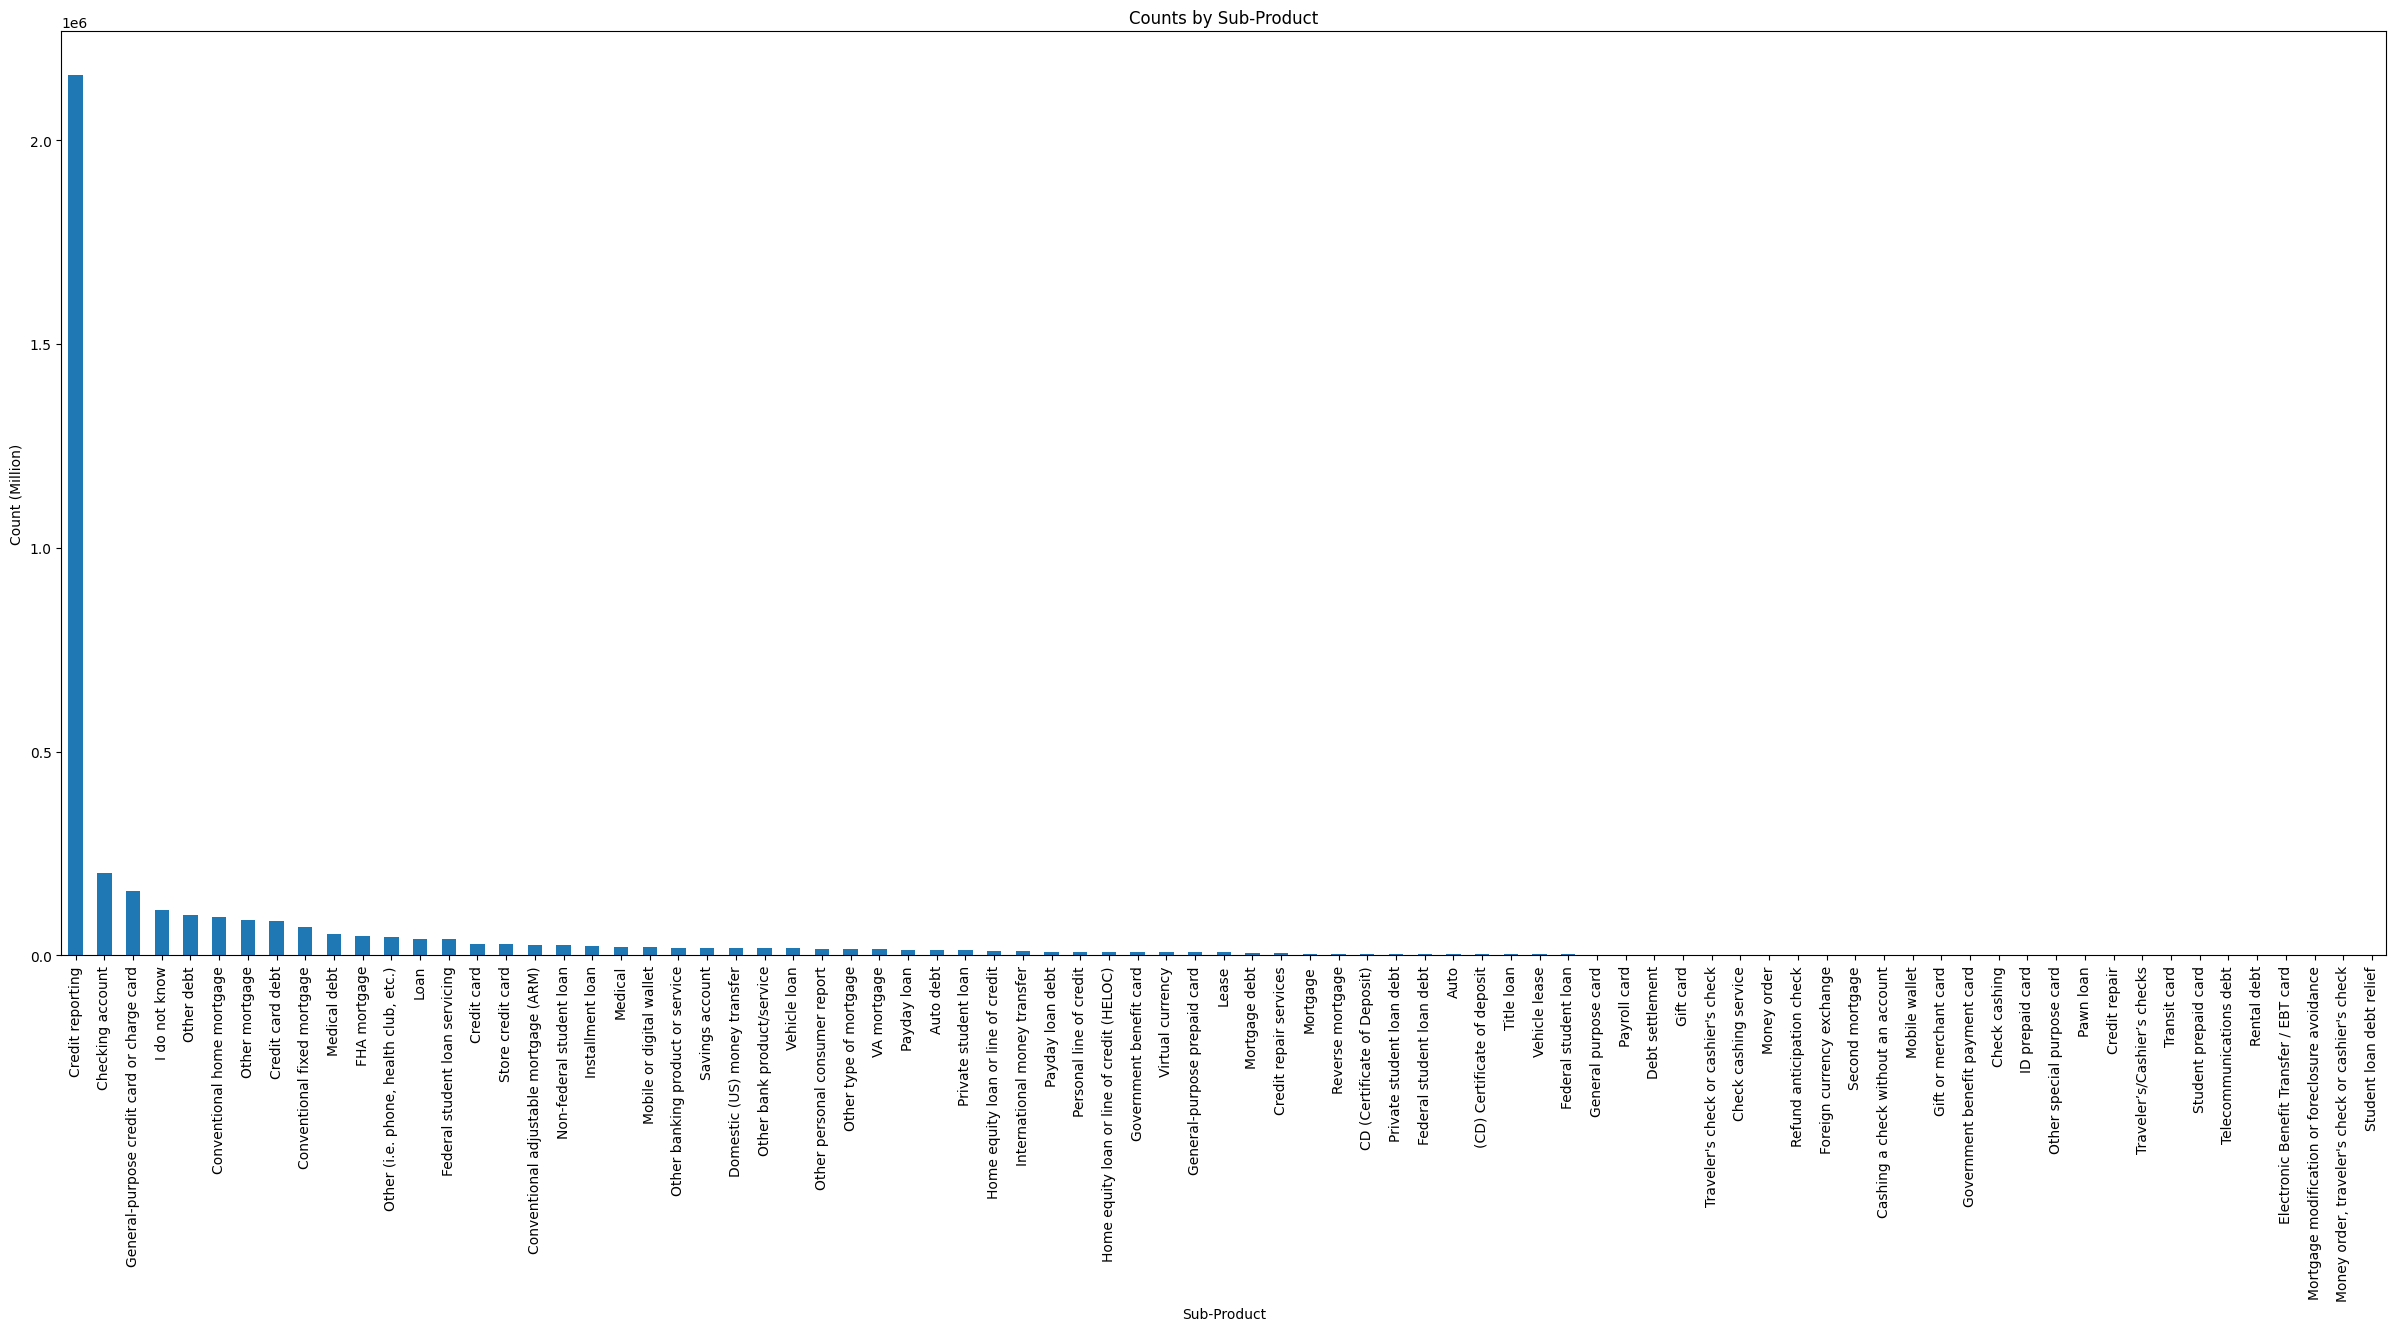

In [ ]:
#calculate the share of the credit reporting of the whole dataset
credit = DATA[DATA['Sub-product'] == 'Credit reporting']
print('Credit Reporting accounts for {}% of the dataset'.format((round(len(credit)/len(DATA)*100,1))))
#visualize the imbalance situation
plt.figure(figsize=(30, 12))
DATA['Sub-product'].value_counts().plot(kind='bar')
plt.title('Counts by Sub-Product')
plt.xlabel('Sub-Product')
plt.ylabel('Count (Million)')
plt.show()

*   **Few Companies**


> From our exploratory data analysis (EDA), we observed that a handful of companies account for a significant portion of the complaint counts. Further examination of the company column showed a notable data disparity, with three particular companies making up roughly 88% of the complaints. Consequently, our team has narrowed our focus on these dominant companies to derive more accurate and contextually relevant insights. For a comprehensive visual representation, please refer to the chart below.

Three companies accounts for 87.9% of the credit dataset


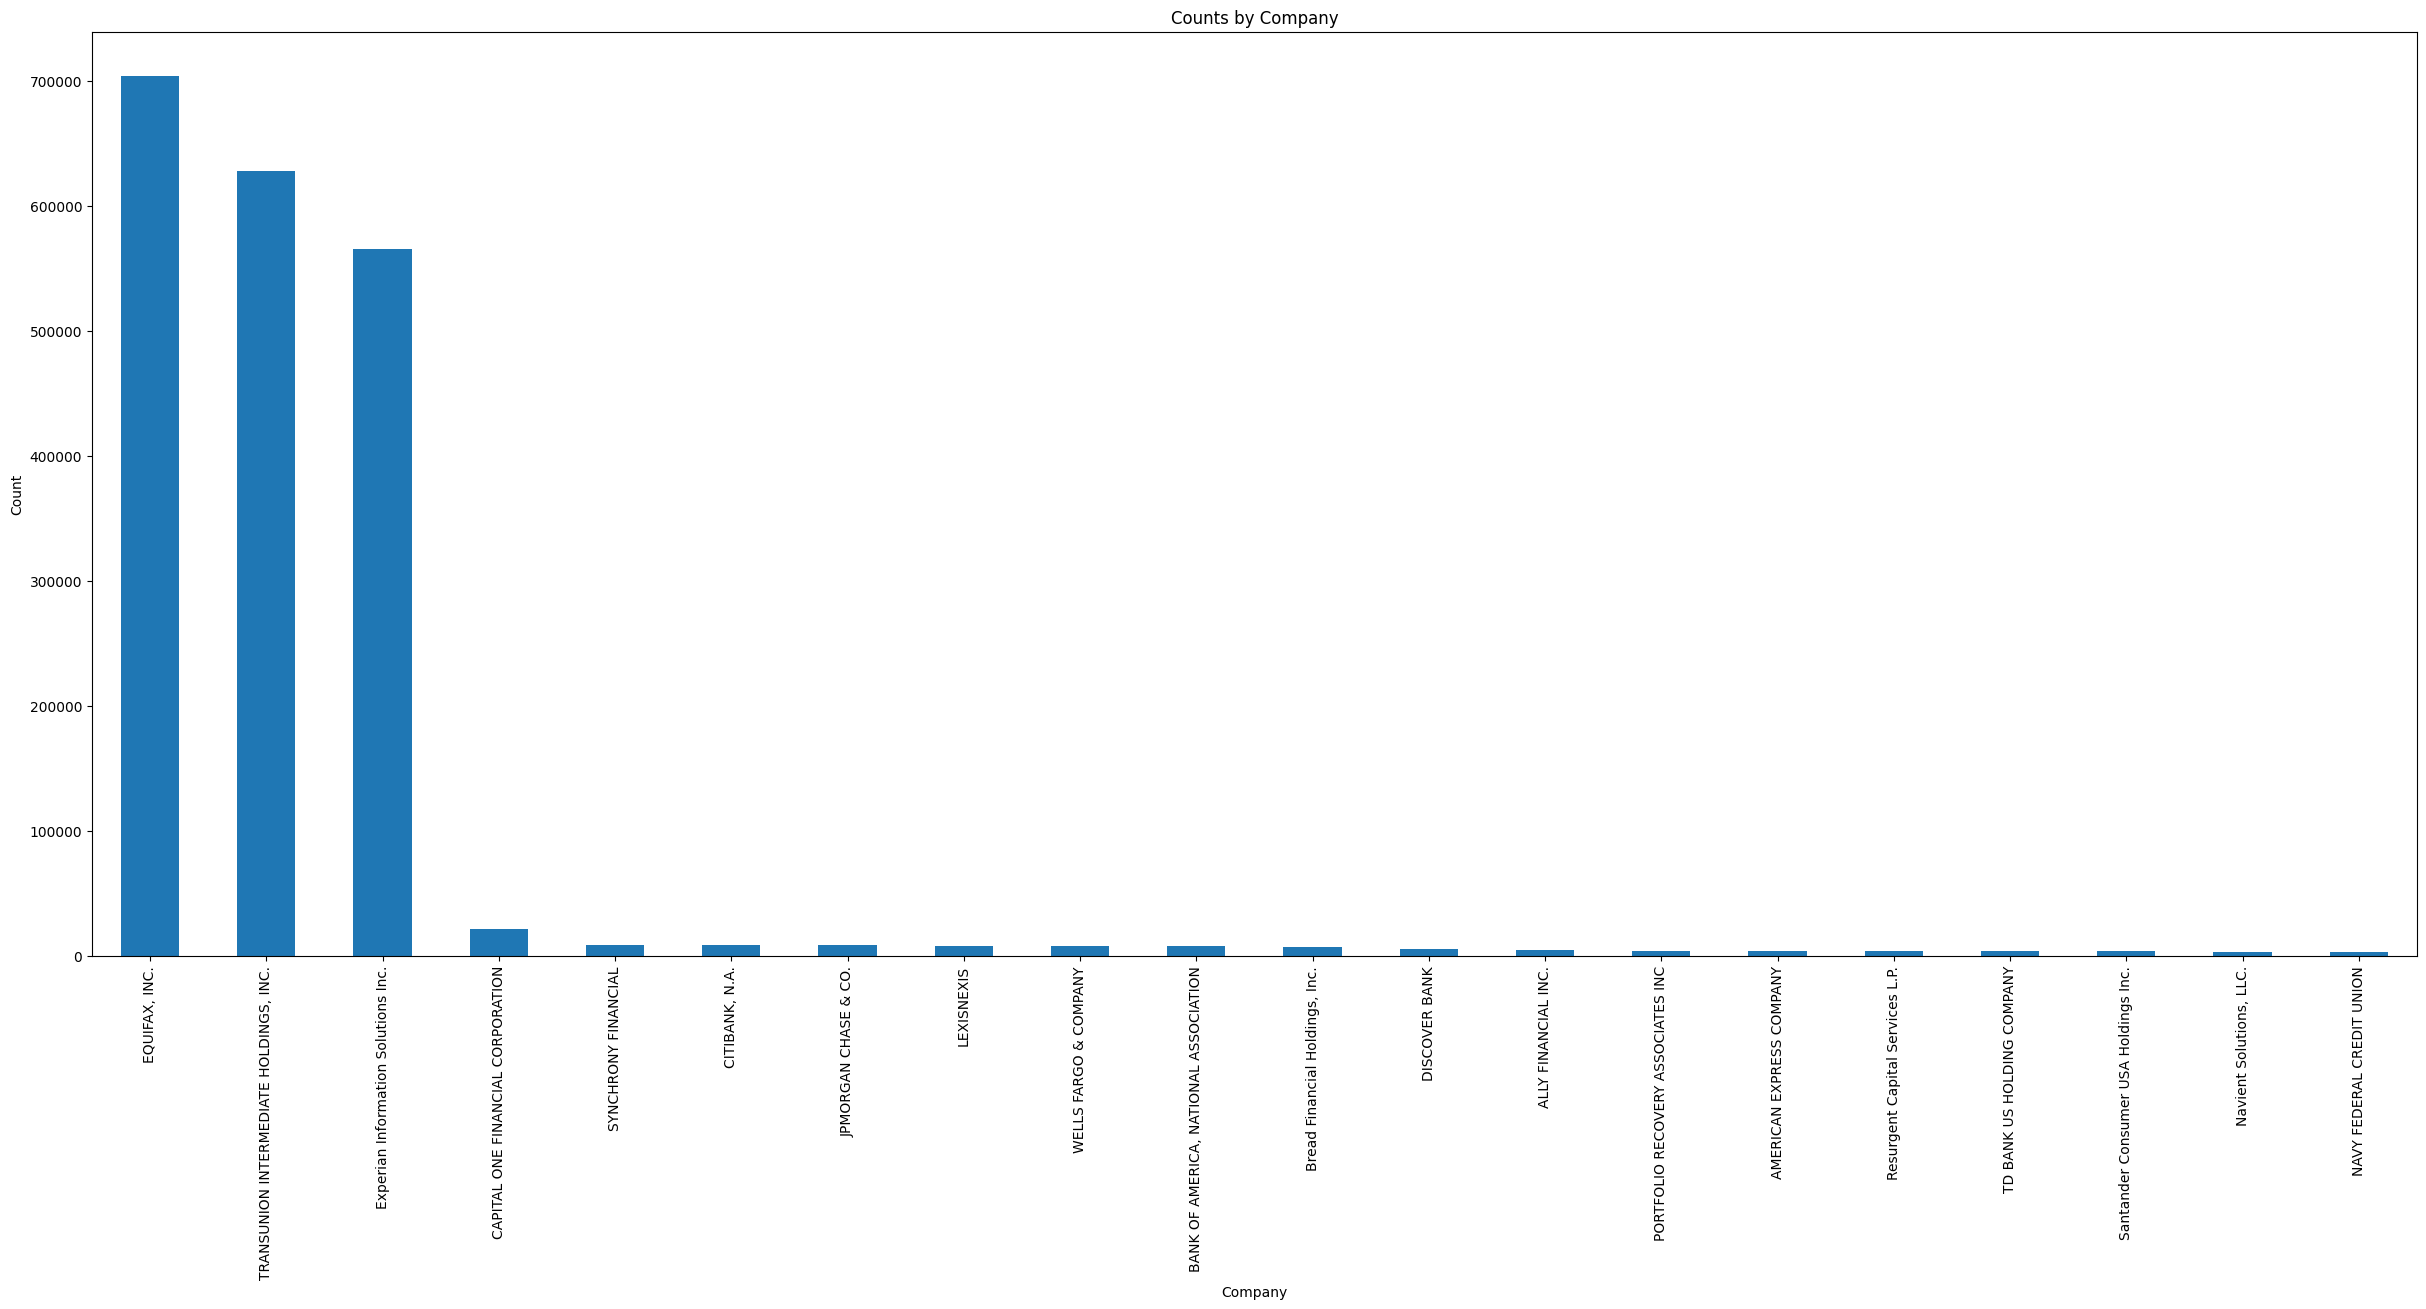

In [ ]:
#calculate the shares of the top three companies of the whole credit reporting dataset
print('Three companies accounts for {}% of the credit dataset'.format((round(credit['Company'].value_counts().head(3).sum()/ len(credit)*100,1))))
#visualize the imbalance situation
plt.figure(figsize=(30, 12))
credit['Company'].value_counts().head(20).plot(kind='bar')
plt.title('Counts by Company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.show()

**Summary: We narrowed down the dataset to focus on credit reporting and three companies: Equifax, Transunion, and Capital One. **


In [ ]:
# Top 3 companies
company = list(credit['Company'].value_counts().head(3).index)
#credit reporting for top 3 companies
credit_company = credit[credit['Company'].isin(company)]
#refined dataframe is what portion of the original dataset
print('credit_company / original dataset: {}%'.format((round(len(credit_company)/len(DATA)*100,1))))

credit_company / original dataset: 47.1%


**Step 2: Feature Selection**


We've excluded the 'Complaint ID', 'Timely response?', 'Consumer consent provided?', 'Submitted via', and 'Tags' from our feature selection. Given that the 'Tags' feature is absent. Moreover, 'Complaint ID' is just a label not related to our focus. Lastly, 'Consumer consent provided?' and 'Submitted via' are removed due to no variance.

In [ ]:
feature_selection = credit_company.drop(columns=['Tags', 'Complaint ID', 'Timely response?', 'Consumer consent provided?', 'Submitted via'])

In [ ]:
feature_selection.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Date sent to company,Company response to consumer,Consumer disputed?
1,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,GA,30318,2023-08-23,Closed with non-monetary relief,NaN
8,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Difficulty submitting a dispute or getting inf...,NaN,NaN,Experian Information Solutions Inc.,NY,10928,2023-08-23,In progress,NaN
11,2023-07-07,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33319,2023-07-07,Closed with non-monetary relief,NaN


**Step 3: Handling Missing Data**


In [ ]:
#As our focus is on the complaint narrative, we dropped rows with no narrative
clean = feature_selection[feature_selection['Consumer complaint narrative'].notnull()]
#notnull narrativ rows are what portion of the original dataset
print('clean / original dataset: {}%'.format((round(len(clean)/len(DATA)*100,1))))
print(clean.shape)
clean.head(3)

clean / original dataset: 15.7%
(631737, 13)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Date sent to company,Company response to consumer,Consumer disputed?
24,2023-07-20,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,641XX,2023-07-20,Closed with non-monetary relief,NaN
28,2023-07-05,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,My name is XXXX XXXX XXXX XXXX this complaint ...,NaN,"EQUIFAX, INC.",FL,33055,2023-07-05,Closed with explanation,NaN
32,2023-07-05,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I've found that my credit report has erroneous...,NaN,"EQUIFAX, INC.",MA,01905,2023-07-05,Closed with non-monetary relief,NaN


**Unexpected Findings**




> Initially, our intention was to train and test solely on the 'credit reporting' sub-product. However, given that none of the entries in this sub-product have a 'consumer disputed' label, we've chosen to designate this dataset as our test set. Instead, we'll leverage other sub-products with 'disputed' data to predict the 'disputed' labels for the 'credit reporting' sub-product entries. Consequently, this curated dataset has transitioned to serve as our test set. Please see the following results.



In [ ]:
#Here this slice of dataset is filtered by whether the narratives is null or not: clean dataframe
#As we know from the EDA, the consumer-disputed Consumer features are missing after 2018. We divided the dataset into two parts: one with Consumer disputes and one without.
consumer_notnull = clean[clean['Consumer disputed?'].notnull()]
consumer_null = clean[clean['Consumer disputed?'].isnull()]
#show the lengths of each
print('Consumer disputed counts for credit reporting: {}'.format(len(consumer_notnull)))
print('Null Consumer disputed counts for credit reporting: {}'.format(len(consumer_null)))
#Credit reporting does not have consumer disputed data
print('The period of this chunk of the dataset was from {} to {}'.format(clean['Date received'].min(), clean['Date received'].max()))

Consumer disputed counts for credit reporting: 0
Null Consumer disputed counts for credit reporting: 631737
The period of this chunk of the dataset was from 2017-04-24 to 2023-08-28




>As we re-examine the filtered dataset by credit reporting and the top three companies, all entries did not have the consumer disputed data.



In [ ]:
#re-examine the credit_company dataset to see the consumer disputed problem
print('Consumer disputed counts for credit reporting and the top three companies without filtering the narratives: {}'.format(len(credit_company[credit_company['Consumer disputed?'].notnull()])))
print('Null Consumer disputed counts for credit reporting and the top three companies without filtering the narratives:  {}'.format(len(credit_company[credit_company['Consumer disputed?'].isnull()])))

Consumer disputed counts for credit reporting and the top three companies without filtering the narratives: 0
Null Consumer disputed counts for credit reporting and the top three companies without filtering the narratives:  1897278


**Re-visit original dataset to examine not credit reporting sub-product**


In [ ]:
#re-examine the DATA to see the consumer disputed problem beside credit-reporting
non_credit = DATA[DATA['Sub-product'] != 'Credit reporting' ]
print('Consumer disputed counts for sub-product other than credit reporting: {}'.format(len(non_credit)))
non_credit.head(3)

Consumer disputed counts for sub-product other than credit reporting: 1869539


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-08-23,"Payday loan, title loan, or personal loan",Installment loan,Problem when making payments,NaN,NaN,NaN,OneMain Finance Corporation,NC,27407,NaN,NaN,Web,2023-08-23,Closed with explanation,Yes,NaN,7448359
3,2023-08-23,Credit card or prepaid card,Store credit card,Fees or interest,Charged too much interest,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",KY,41018,Older American,NaN,Phone,2023-08-23,Closed with explanation,Yes,NaN,7442765
5,2023-08-23,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,NaN,NaN,"LTD Financial Services, L.P.",NJ,08046,Servicemember,NaN,Web,2023-08-23,In progress,Yes,NaN,7447784




> From the below counts, we identified around 768 thousand entries with the consumer disputed label, so we will use this chunk of the dataset to build up the model to predict the consumer disputed label for the credit reporting sub-product.



In [ ]:
print('not credit reporting Consumer disputed counts: {}'.format(len(non_credit[non_credit['Consumer disputed?'].notnull()])))
print('not credit reporting Null Consumer disputed counts: {}'.format(len(non_credit[non_credit['Consumer disputed?'].isnull()])))

not credit reporting Consumer disputed counts: 768358
not credit reporting Null Consumer disputed counts: 1101181


**Examine the not credit reporting sub-products' distribution**


Complaint disputed Sub-product accounts for 12.7% of the original dataset


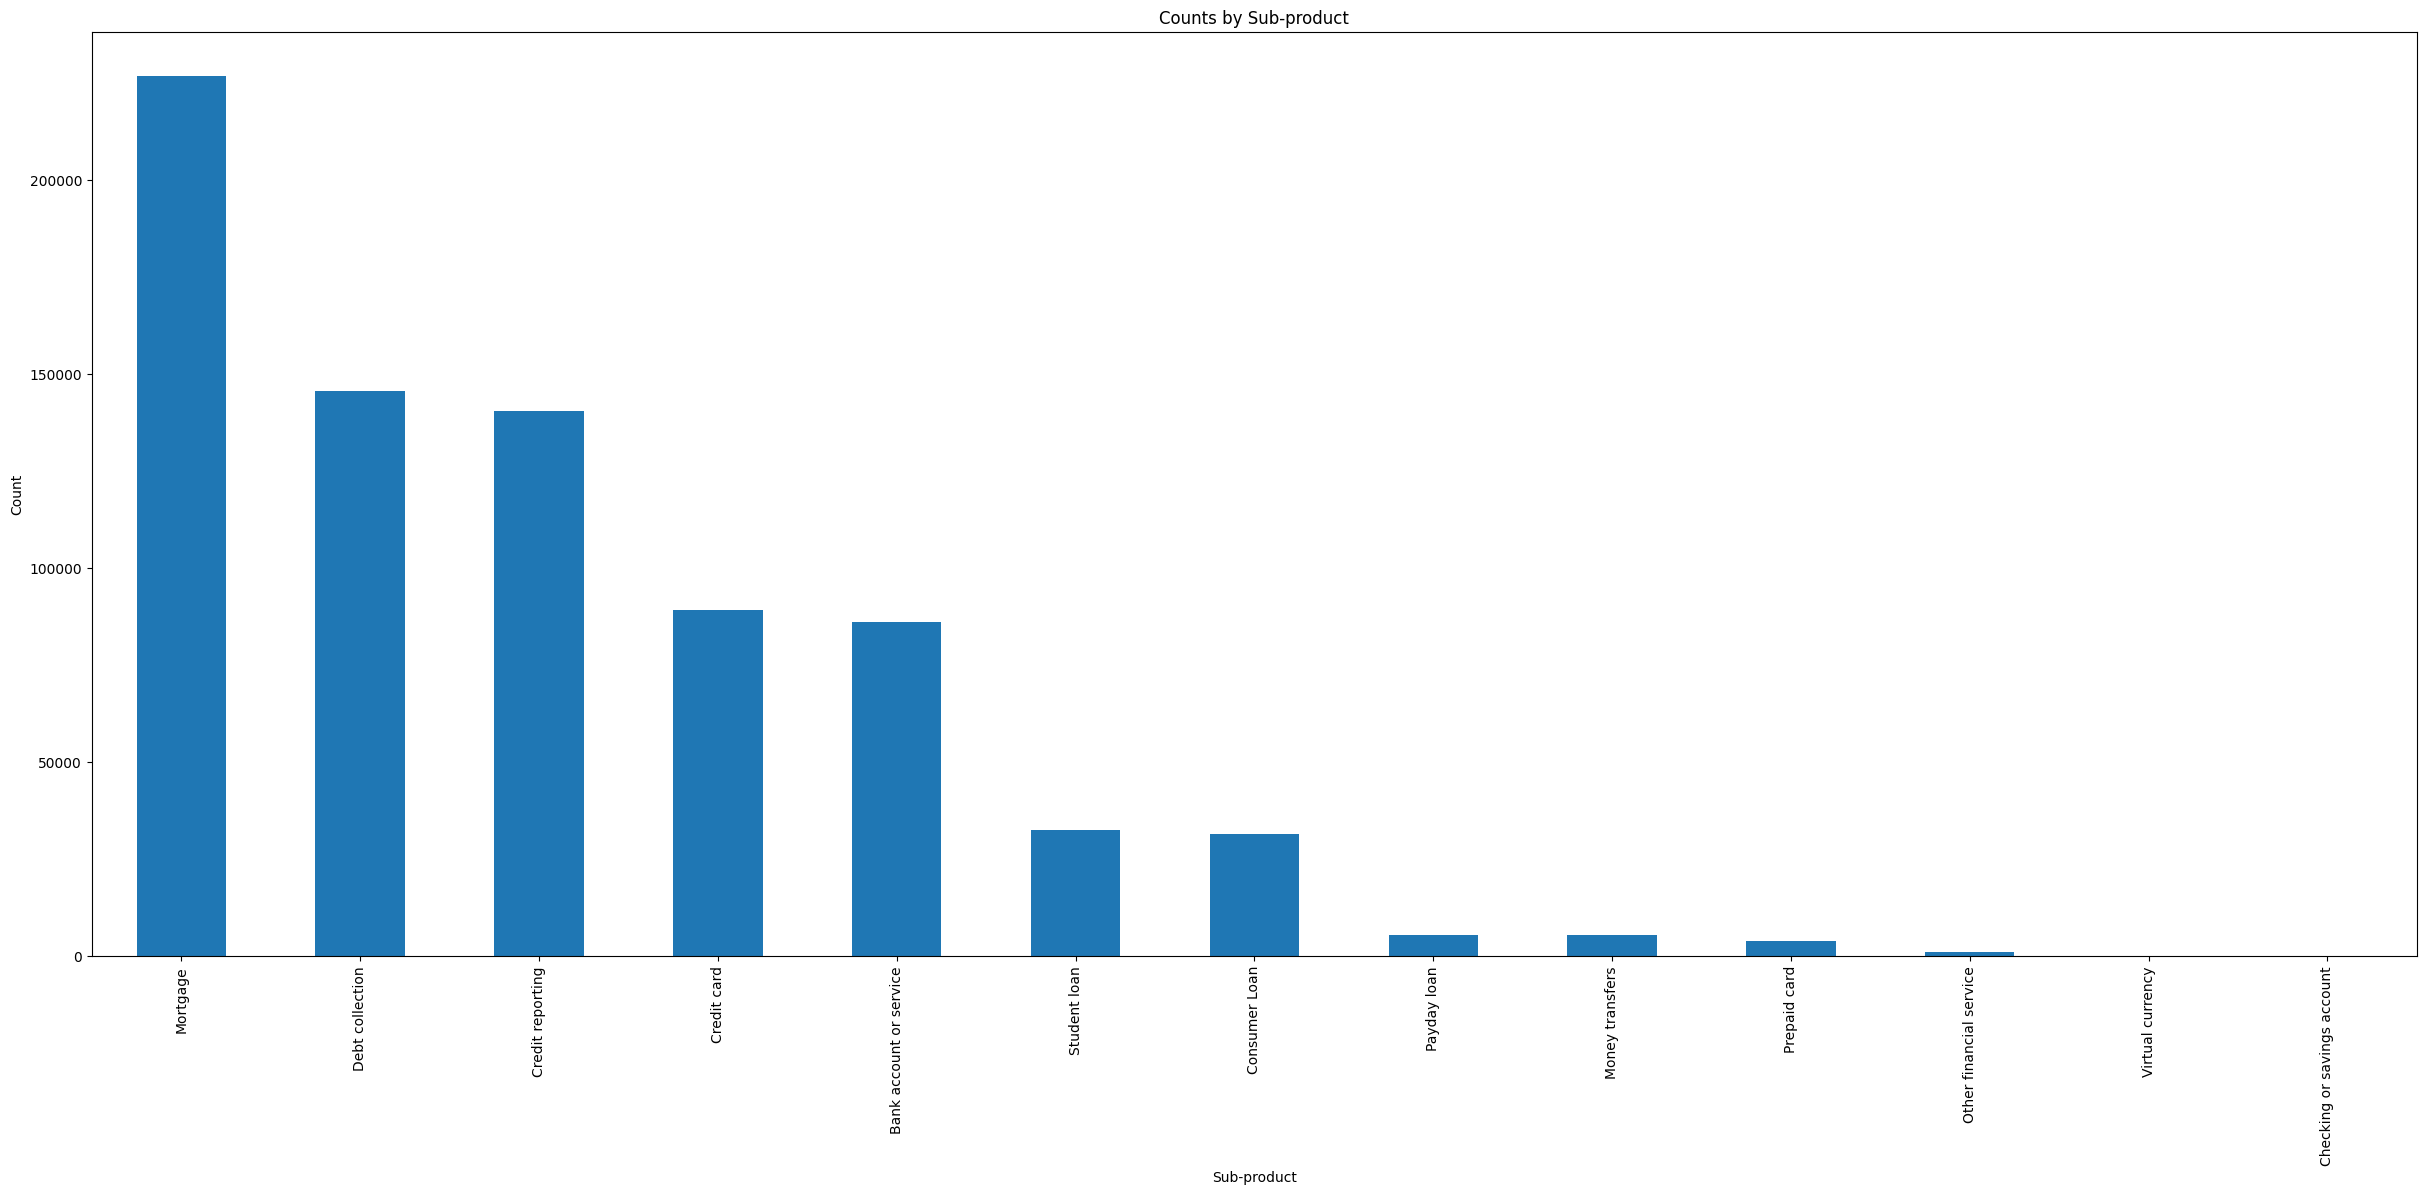

In [ ]:
# define disputed dataframe
disputed = DATA[(DATA['Sub-product'] != 'Credit reporting') & (DATA['Consumer disputed?'].notnull())]
#calculate the shares of the top three companies of the whole credit reporting dataset
print('Complaint disputed Sub-product accounts for {}% of the original dataset'.format((round(disputed['Product'].value_counts().head(3).sum()/ len(DATA)*100,1))))
#visualize the imbalance situation
plt.figure(figsize=(30, 12))
disputed['Product'].value_counts().head(20).plot(kind='bar')
plt.title('Counts by Sub-product')
plt.xlabel('Sub-product')
plt.ylabel('Count')
plt.show()



> We found that the first eleven sub-products account for about 99.99% of the not credit reporting part of the dataset.



In [ ]:
#check the shares of the first 11 Products / all Products
print('Top 11 sub-products account for {}% of the not credit reporting'.format(round(disputed['Product'].value_counts().head(11).sum()/disputed['Product'].value_counts().sum()*100,3)))

Top 11 sub-products account for 99.997% of the not credit reporting




> As we decided to use the data points with disputed labels, we will use the disputed dataframe as our training set. The below analysis shows the null percent of each feature.



In [ ]:
#check the null % for each feature
train_valid = disputed.drop(columns=['Tags', 'Complaint ID', 'Timely response?', 'Consumer consent provided?', 'Submitted via'])
train_valid.isnull().sum() / len(train_valid) * 100

Date received                    0.000000
Product                          0.000000
Sub-product                     30.605525
Issue                            0.000000
Sub-issue                       59.265342
Consumer complaint narrative    78.651358
Company public response         74.528931
Company                          0.000000
State                            0.735334
ZIP code                         0.501980
Date sent to company             0.000000
Company response to consumer     0.000000
Consumer disputed?               0.000000
dtype: float64



> The below analysis checks the null percentage of each feature of the credit reporting slices.



In [ ]:
#check the null % for each feature
consumer_null.isnull().sum() / len(consumer_null) * 100

Date received                     0.000000
Product                           0.000000
Sub-product                       0.000000
Issue                             0.000000
Sub-issue                         0.963059
Consumer complaint narrative      0.000000
Company public response          36.221561
Company                           0.000000
State                             0.125527
ZIP code                          0.000000
Date sent to company              0.000000
Company response to consumer      0.000317
Consumer disputed?              100.000000
dtype: float64



> Based on our analyses of the two sets, we observed that the set has significant null values across multiple features. To ensure consistency between the training and test sets, we removed certain features that were deemed redundant or had high missing values. Specifically, we eliminated the 'sub-product' feature because 30% of its values were missing in the training set, whereas none were in the predict set. Instead, we have utilized the 'product' feature, which has complete data in both sets. Similarly, we discarded the 'sub-issue' and retained the 'issue' feature for consistency. We also removed rows in the training set that lacked narratives and omitted the 'company public response' feature due to its substantial missing data in both sets. Finally, considering both convey similar information, we retained the 'zip code' and discarded the 'state' feature. Below two analyses shows the results after our processing.



In [ ]:
train_valid_narr = train_valid[train_valid['Consumer complaint narrative'].notnull()]
train_valid_narr_refine = train_valid_narr.drop(columns=['Sub-product','Sub-issue', 'Company public response', 'State'])
train_valid_narr_refine.isnull().sum() / len(train_valid_narr_refine) * 100

Date received                   0.0
Product                         0.0
Issue                           0.0
Consumer complaint narrative    0.0
Company                         0.0
ZIP code                        0.0
Date sent to company            0.0
Company response to consumer    0.0
Consumer disputed?              0.0
dtype: float64

In [ ]:
#check the null % for each feature
consumer_null_refine = consumer_null.drop(columns=['Sub-product', 'Sub-issue', 'Company public response', 'State'])
consumer_null_refine = consumer_null_refine[consumer_null_refine['Company response to consumer'].notnull()]
consumer_null_refine.isnull().sum() / len(consumer_null_refine) * 100

Date received                     0.0
Product                           0.0
Issue                             0.0
Consumer complaint narrative      0.0
Company                           0.0
ZIP code                          0.0
Date sent to company              0.0
Company response to consumer      0.0
Consumer disputed?              100.0
dtype: float64



> Transform the date related features into datetime and the calculate the difference between Data received and Date set to company as the new feature "days". Moreover, we converted the labels of the consumer disputed into 0 and 1.



In [ ]:
# convert date received and date sent to company to datetime format, and compute date sent - date received, store in column 'days' as int
train_valid_narr_refine['Date received'] = pd.to_datetime(train_valid_narr_refine['Date received'])
train_valid_narr_refine['Date sent to company'] = pd.to_datetime(train_valid_narr_refine['Date sent to company'])
train_valid_narr_refine['days'] = (train_valid_narr_refine['Date sent to company'] - train_valid_narr_refine['Date received']).dt.days

# drop Date received and Date sent to company columns
train_valid_narr_refine.drop(['Date received', 'Date sent to company'], axis=1, inplace=True)
train_valid_narr_refine.head(3)

,Product,Issue,Consumer complaint narrative,Company,ZIP code,Company response to consumer,Consumer disputed?,days
31338,Mortgage,Settlement process and costs,"XXXX XXXX, 2016 To Whom It May Concern : I am ...","Barrett Financial Group, L.L.C.",92071,Closed with monetary relief,Yes,61
31664,Consumer Loan,Managing the loan or lease,History of account : I am a co-signer on XXXX ...,Bridgecrest Acceptance Corporation,85340,Closed with explanation,Yes,2
35599,Credit card,Billing disputes,I have excellent credit and the only times I m...,SYNCHRONY FINANCIAL,21229,Closed with explanation,Yes,0


In [ ]:
# encode disputed column to 0 and 1
train_valid_narr_refine['Consumer disputed?'] = train_valid_narr_refine['Consumer disputed?'].map({'No': 0, 'Yes': 1})
train_valid_narr_refine.head(3)

,Product,Issue,Consumer complaint narrative,Company,ZIP code,Company response to consumer,Consumer disputed?,days
31338,Mortgage,Settlement process and costs,"XXXX XXXX, 2016 To Whom It May Concern : I am ...","Barrett Financial Group, L.L.C.",92071,Closed with monetary relief,1,61
31664,Consumer Loan,Managing the loan or lease,History of account : I am a co-signer on XXXX ...,Bridgecrest Acceptance Corporation,85340,Closed with explanation,1,2
35599,Credit card,Billing disputes,I have excellent credit and the only times I m...,SYNCHRONY FINANCIAL,21229,Closed with explanation,1,0


In [ ]:
# convert date received and date sent to company to datetime format, and compute date sent - date received, store in column 'days' as int
consumer_null_refine['Date received'] = pd.to_datetime(consumer_null_refine['Date received'])
consumer_null_refine['Date sent to company'] = pd.to_datetime(consumer_null_refine['Date sent to company'])
consumer_null_refine['days'] = (consumer_null_refine['Date sent to company'] - consumer_null_refine['Date received']).dt.days

# drop Date received and Date sent to company columns
consumer_null_refine.drop(['Date received', 'Date sent to company'], axis=1, inplace=True)
consumer_null_refine.head(3)

,Product,Issue,Consumer complaint narrative,Company,ZIP code,Company response to consumer,Consumer disputed?,days
24,"Credit reporting, credit repair services, or o...",Improper use of your report,In accordance with the Fair Credit Reporting a...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",641XX,Closed with non-monetary relief,NaN,0
28,"Credit reporting, credit repair services, or o...",Improper use of your report,My name is XXXX XXXX XXXX XXXX this complaint ...,"EQUIFAX, INC.",33055,Closed with explanation,NaN,0
32,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,I've found that my credit report has erroneous...,"EQUIFAX, INC.",01905,Closed with non-monetary relief,NaN,0




*   Training Set before Vectorization



In [ ]:
train_df_before_vector = train_valid_narr_refine.copy()
print('Training set: {} rows'.format(len(train_df_before_vector)))

Training set: 164034 rows




*   Prediction set before Vectorization



In [ ]:
predict_df_before_vector = consumer_null_refine.copy()
print('Test set: {} rows'.format(len(predict_df_before_vector)))

Test set: 631735 rows


**Step 4: Word Embedding and Feature Vectorization**


<font color='orange'> **Grasp a fractoin of sample from the original dataframes for testing purpose. Please comment out the below line before training on the complete dataframe.   **<font>

In [ ]:
# Grasp a fractoin of sample from dataframe just for testing purpose
train_df_before_vector = train_df_before_vector.sample(frac=0.5, random_state=42)

predict_df_before_vector = predict_df_before_vector.sample(frac=0.5, random_state=42)

In [ ]:
# import word2vec model (this take a while to load)
word2vec = KeyedVectors.load_word2vec_format(file_path_03, binary=True)

In [ ]:
# helper func: preprocess the narrative column

def preprocess_narrative(text):

    # Lowercase
    text = text.lower()

    # Remove XXXX like pattern
    text = re.sub(r'x{2,}', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces
    text = text.strip()

    return text



> Approach: Mixture of categorical columns and TFIDF w2v matrix



In [ ]:
# preprocess narrative column and store in narrative_processed column
train_df_before_vector['narrative_processed'] = train_df_before_vector['Consumer complaint narrative'].progress_apply(preprocess_narrative)
predict_df_before_vector['narrative_processed'] = predict_df_before_vector['Consumer complaint narrative'].progress_apply(preprocess_narrative)

100%|██████████| 315868/315868 [00:28<00:00, 11109.14it/s]


In [ ]:
# instantiate tfidf

tfidf = TfidfVectorizer()

# fit and transform tfidf vectorizer on narrative_processed column
tfidf.fit(train_df_before_vector.narrative_processed)

# get tfidf feature names
tfidf_features = tfidf.get_feature_names_out()

# get tfidf weights
tfidf_weights = tfidf.idf_


In [ ]:
# define a function get mean word2vec vector for a narrative

def get_mean_word2vec(narrative):

    # initialize vector
    vector = np.zeros(300)

    # get all words in narrative
    words = narrative.split()
    num_words = len(words)

    if num_words == 0:  # edge case: empty narrative
        return vector

    # calculate word vectors using list comprehension
    word_vectors = [word2vec[word] for word in words if word in word2vec]

    if word_vectors:
        vector = np.mean(word_vectors, axis=0)

    return vector


# define a function get mean tfidf weighted word2vec vector for a narrative
def get_mean_tfidf_weighted_word2vec(narrative):

    # initialize vector
    vector = np.zeros(300)

    # get all words in narrative
    words = narrative.split()
    num_words = len(words)

    if num_words == 0:  # edge case: empty narrative
        return vector

    # pre-calculate word-to-index mapping for tfidf_features for O(1) lookup
    word_to_index = {word: idx for idx, word in enumerate(tfidf_features)}

    # calculate word vectors using list comprehension
    word_vectors = [
        word2vec[word] * tfidf_weights[word_to_index[word]]
        for word in words if word in word2vec and word in word_to_index
    ]

    if word_vectors:
        vector = np.sum(word_vectors, axis=0) / num_words

    return vector

In [ ]:
# compute mean tfidf weighted word2vec vector for each narrative (take a while)
train_df_before_vector['narrative_tw'] = train_df_before_vector['narrative_processed'].progress_apply(get_mean_tfidf_weighted_word2vec)
predict_df_before_vector['narrative_tw'] = predict_df_before_vector['narrative_processed'].progress_apply(get_mean_tfidf_weighted_word2vec)
# convert train_df_before_vector['narrative_tw'] to numpy array tw_array
tw_array_train = np.array(train_df_before_vector.narrative_tw.tolist())
# convert test_df_before_vector['narrative_tw'] to numpy array tw_array
tw_array_predict = np.array(predict_df_before_vector.narrative_tw.tolist())
# print shape of tw_array
print('Train: {}'.format(tw_array_train.shape))
print('Test: {}'.format(tw_array_predict.shape))

100%|██████████| 315868/315868 [52:27<00:00, 100.34it/s]


Train: (82017, 300)
Test: (315868, 300)


In [ ]:
# copy target column to y
y = train_df_before_vector['Consumer disputed?'].copy()

In [ ]:
train_df_before_vector.columns

Index(['Product', 'Issue', 'Consumer complaint narrative', 'Company',
       'ZIP code', 'Company response to consumer', 'Consumer disputed?',
       'days', 'narrative_processed', 'narrative_tw'],
      dtype='object')

In [ ]:
# drop Consumer complaint narrative, narrative_processed, Consumer disputed? columns
train_df_before_vector.drop(['Consumer complaint narrative', 'narrative_processed', 'narrative_tw', 'Consumer disputed?'], axis=1, inplace=True)
predict_df_before_vector.drop(['Consumer complaint narrative', 'narrative_processed', 'narrative_tw', 'Consumer disputed?'], axis=1, inplace=True)

In [ ]:
train_df_before_vector.nunique()

Product                           12
Issue                             91
Company                         2529
ZIP code                        6767
Company response to consumer       5
days                             199
dtype: int64

In [ ]:
predict_df_before_vector.nunique()

Product                            2
Issue                             11
Company                            3
ZIP code                        6789
Company response to consumer       5
days                              81
dtype: int64

<font color='orange'>Dora: I am not very sure about why we are doing this concatenation step >_<  
If we still want to SMOTE for both Nominal and Continuous data, we can use SMOTENC. </font>

In [ ]:
# concatenate tw_array_train with train_df_before_vector
# X = np.concatenate((tw_array_train, train_df_before_vector), axis=1)
# X_predict = np.concatenate((tw_array_predict, predict_df_before_vector), axis=1)


X = tw_array_train
X_predict = tw_array_predict
# check shape of X
print('X.shape: {}'.format(X.shape))
print('X_predict.shape: {}'.format(X_predict.shape))
print('y.shape: {}'.format(y.shape))

X.shape: (82017, 300)
X_predict.shape: (315868, 300)
y.shape: (82017,)


In [ ]:
# smoote to oversample minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# print shape of X_smote, y_smote
print(X_smote.shape, y_smote.shape)

(128452, 300) (128452,)


# Run the models and evaluations

To enhance the robustness of our predictive models' evaluation, we are employing K-fold cross-validation across the models in our analysis.

In [ ]:
!pip install scikeras[tensorflow]
!pip install scikit-optimize
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn import metrics
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
# train with logistic regression and do cross-validation, wrap in a function

def cross_val_lr(X_smote, y_smote, k):

    # Define a pipeline consisting of preprocessing and model
    pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

    # Perform 5-fold cross-validation with the pipeline
    scores = cross_val_score(pipe, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    print(f"Mean score of cross validation: {scores.mean()}")
    return scores.mean()



# train naive bayes and do cross-validation

def cross_val_naive_bayes(X_smote, y_smote, k):

    # Define a pipeline consisting of preprocessing and model
    # scale values as nb not working with negative
    pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', MultinomialNB())])

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(pipe, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean()

# train lightgbm and do cross-validation

def cross_val_lgbm(X_smote, y_smote, k):

    # instantiate lightgbm model
    classifier = LGBMClassifier(random_state=42)

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(classifier, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean()


# train with xgboost

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Starting in XGBoost")

def cross_val_xgb(X_smote, y_smote, k):

    # instantiate xgboost model
    classifier = XGBClassifier(random_state=42, n_jobs=-1)

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(classifier, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean()


# catboost in a function

def cross_val_catboost(X_smote, y_smote, k):

    # instantiate catboost model
    classifier = CatBoostClassifier(random_state=42)

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(classifier, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean()


# train ann

def create_ann_model(X_smote):

    # instantiate ann model
    ann = Sequential()

    # add input layer
    ann.add(Dense(128, activation='relu', input_shape=(X_smote.shape[1],)))

    # add hidden layers
    ann.add(Dense(64, activation='relu'))
    ann.add(Dense(32, activation='relu'))
    ann.add(Dense(16, activation='relu'))

    # add output layer
    ann.add(Dense(1, activation='sigmoid'))

    # compile model
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return ann

In [ ]:
# Check the mean F1 score for logistic regression

model_lr = cross_val_lr(X_smote, y_smote, k=5)

Mean score of cross validation: 0.5854778131217412


In [ ]:
# Check the mean F1 score for naive bayes,

model_nb = cross_val_naive_bayes(X_smote, y_smote, k=5)

Mean score of cross validation: 0.550830631496452


In [ ]:
# Check the mean F1 score for lightgbm

model_lgbm = cross_val_lgbm(X_smote, y_smote, k=5)

[LightGBM] [Info] Number of positive: 51381, number of negative: 51380
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 102761, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000019
[LightGBM] [Info] Start training from score 0.000019
[LightGBM] [Info] Number of positive: 51380, number of negative: 51381
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 102761, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499995 -> initscore=-0.000019
[LightGBM] [Info] Start training from score -0.000019
[L

In [ ]:
# Check the mean F1 score for xgboost

model_xgb = cross_val_xgb(X_smote, y_smote, k=5)

Mean score of cross validation: 0.7484704568191674


In [ ]:
# Check the mean F1 score for catboost

model_catboost = cross_val_catboost(X_smote, y_smote, k=5)

串流輸出內容已截斷至最後 5000 行。
5:	learn: 0.6634258	total: 290ms	remaining: 48s
6:	learn: 0.6594647	total: 328ms	remaining: 46.5s
7:	learn: 0.6557958	total: 365ms	remaining: 45.3s
8:	learn: 0.6521858	total: 404ms	remaining: 44.5s
9:	learn: 0.6488530	total: 443ms	remaining: 43.8s
10:	learn: 0.6454949	total: 479ms	remaining: 43.1s
11:	learn: 0.6423952	total: 515ms	remaining: 42.4s
12:	learn: 0.6394935	total: 552ms	remaining: 41.9s
13:	learn: 0.6366987	total: 591ms	remaining: 41.7s
14:	learn: 0.6340524	total: 629ms	remaining: 41.3s
15:	learn: 0.6316519	total: 669ms	remaining: 41.2s
16:	learn: 0.6293543	total: 709ms	remaining: 41s
17:	learn: 0.6270105	total: 754ms	remaining: 41.1s
18:	learn: 0.6248315	total: 793ms	remaining: 41s
19:	learn: 0.6225974	total: 831ms	remaining: 40.7s
20:	learn: 0.6205053	total: 868ms	remaining: 40.5s
21:	learn: 0.6185782	total: 906ms	remaining: 40.3s
22:	learn: 0.6166893	total: 945ms	remaining: 40.1s
23:	learn: 0.6149339	total: 982ms	remaining: 39.9s
24:	learn: 0.6131257	

In [ ]:
# train ann
model_ann = create_ann_model(X_smote)

# Instantiate KerasClassifier with ANN model creation function
ann_classifier = KerasClassifier(build_fn=create_ann_model(X_smote), epochs=10, batch_size=32, verbose=0)

# conduct cross validation and get scores
scores = cross_val_score(ann_classifier, X_smote, y_smote, cv=5, scoring = "f1_macro")

# Check the mean F1 score for ann
print(f"Mean score of cross validation: {scores.mean()}")

Mean score of cross validation: 0.7336110692838165


As seen above, XGBoost classifier outputs the highest f1-score through k-fold cross validation. We then use Bayesian optimization to perform a hyperparametre search for finding the optimized hyperparameters for the model.

In [ ]:
# train test split, 20% test, random_state=42, stratify=y_smote
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify=y_smote, random_state=42, test_size=0.2)

# print shape
print(X_smote_train.shape, X_smote_test.shape, y_smote_train.shape, y_smote_test.shape)

(102761, 300) (25691, 300) (102761,) (25691,)


In [ ]:
def bayes_search_xgboost(X_smote_train, y_smote_train, search_space, cv=5, scoring='f1_macro'):

    # instantiate xgboost model
    classifier = XGBClassifier(random_state=42)

    # Create BayesSearchCV object with pipeline
    opt = BayesSearchCV(
    estimator=classifier,
    search_spaces=search_space,
    cv=5,
    scoring="f1_macro",
    random_state=42,
    n_iter=3,
    verbose=1,
)

    # Fit the search to our data
    opt.fit(X_smote_train, y_smote_train)

    print("Best Hyperparameters: %s" % str(opt.best_params_))
    print("val. F1 score: %s" % opt.best_score_)
    print("test F1 score: %s" % opt.score(X_smote_test, y_smote_test))

    return opt.best_score_

In [ ]:
search_space = {'max_depth': (3, 9),'learning_rate': (0.01, 0.5)}

bayes_search_xgboost(X_smote_train, y_smote_train, search_space=search_space, cv=5, scoring='f1_macro')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: OrderedDict([('learning_rate', 0.2279679310275644), ('max_depth', 9)])
val. F1 score: 0.8097774409495966
test F1 score: 0.8268458870383233


0.8097774409495966

The score on test set and validation set look both fine! We then plot a confusion matrix to check the Precision and Recall situation.

In [ ]:
# set the XGBoost classifier with the best hyperparameters from BayesSearchCV
xgboost = XGBClassifier(random_seed=42, learning_rate=0.2279679310275644, max_depth=9)

# fit model
xgboost.fit(X_smote_train, y_smote_train)

# predict on test set
y_smote_pred = xgboost.predict(X_smote_test)

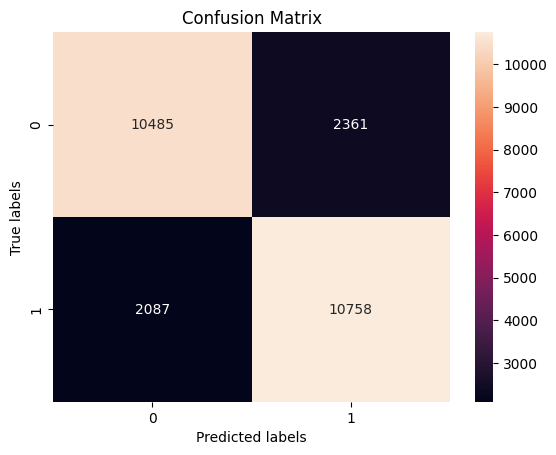

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_smote_test, y_smote_pred)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells

# set labels snf title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()

In [ ]:
print('Recall: {}'.format(confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[1][0])))
print('Precision: {}'.format(confusion_matrix[1][1] / (confusion_matrix[0][1] + confusion_matrix[1][1])))
print('Accuracy: {}'.format((confusion_matrix[0][0]+confusion_matrix[1][1]) / confusion_matrix.sum()))

Recall: 0.8375243285325029
Precision: 0.8200320146352619
Accuracy: 0.8268654392588844


*Below are code for Grid Search, as back up.*

In [ ]:
from sklearn.model_selection import GridSearchCV

def grid_search_xgboost(X_smote, y_smote, param_grid, cv=5, scoring='f1_macro'):

    # instantiate xgboost model
    classifier = XGBClassifier(random_state=42)

    # Create GridSearchCV object with the pipeline and parameter grid
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='f1_macro')

    # Fit the grid search to data
    grid_search.fit(X_smote, y_smote)


    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best F1 Score:", grid_search.best_score_)

    return grid_search.best_estimator_

In [ ]:
# Define the parameter grid for grid search
param_grid = {'classifier__depth': [4, 5, 6],
              'classifier__learning_rate':[0.01,0.02,0.03,0.04]
         }
# Perform grid search for Catboost hyperparameters
best_model = grid_search_xgboost(X_smote, y_smote, param_grid)

KeyboardInterrupt: ignored